King County Housing Data Linear Regression
Nashaat Khan


In [121]:
#Importing all packages to be used for linear regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [122]:
df=pd.read_csv('/Users/nashaat/Downloads/kc_house_data.csv')

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Large dataset w/ no null values. Numeric data so linear regression can be done

In [124]:
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [125]:
#Checking for missing values

for column in df.columns:
    proportion_of_nas = (sum(df[column].isnull())/len(df[column])) * 100 
    print(column, proportion_of_nas)

id 0.0
date 0.0
price 0.0
bedrooms 0.0
bathrooms 0.0
sqft_living 0.0
sqft_lot 0.0
floors 0.0
waterfront 0.0
view 0.0
condition 0.0
grade 0.0
sqft_above 0.0
sqft_basement 0.0
yr_built 0.0
yr_renovated 0.0
zipcode 0.0
lat 0.0
long 0.0
sqft_living15 0.0
sqft_lot15 0.0


Next, we will check for outliers in bed and bathroom to ensure we have only single family homes. We will drop any values that are 3 standard deviations away from the mean in bed and bathroom. For example: houses with 6 bathrooms and 11+ bedrooms are clearly not single family homes, therefore are outliers.

In [126]:
#Bathrooms outliers
count = 0
bathroom_out = []
mean = np.mean(df['bathrooms'])
max_distance = np.std(df['bathrooms']) * 3 

for idx, row in df['bathrooms'].T.items():
    if abs(row-mean) >= max_distance:
        count += 1
        df.drop(idx, inplace=True)
count

187

In [127]:
#Bedroom outliers
count = 0
bedroom_out = []
mean = np.mean(df['bedrooms'])
max_distance = np.std(df['bedrooms']) * 3 

for idx, row in df['bedrooms'].T.items():
    if abs(row-mean) >= max_distance:
        count += 1
        df.drop(idx,inplace=True)
count

60

Thus, there were NO bathroom outliers & 60 bedroom outliers. All of these extreme values were dropped to ensure single family homes

FEATURE ENGINNERING:

Next, we will develop scatterplot to understand how conditions and grade are correlated w/ house price. We may have to do feature enginneing with one hot encoding to get better understanding of the data.

Text(0.5, 1.0, 'House Condition vs Price')

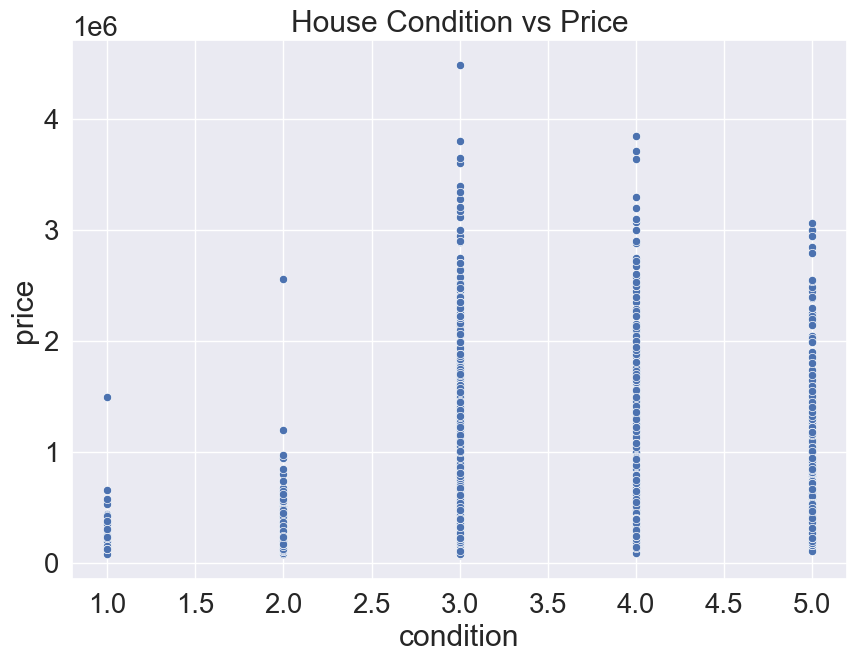

In [128]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x= "condition", y="price")
plt.title('House Condition vs Price')

No clear linear relationship, lets discern relationship with grade and condition

Text(0.5, 1.0, 'House Condition vs Grade')

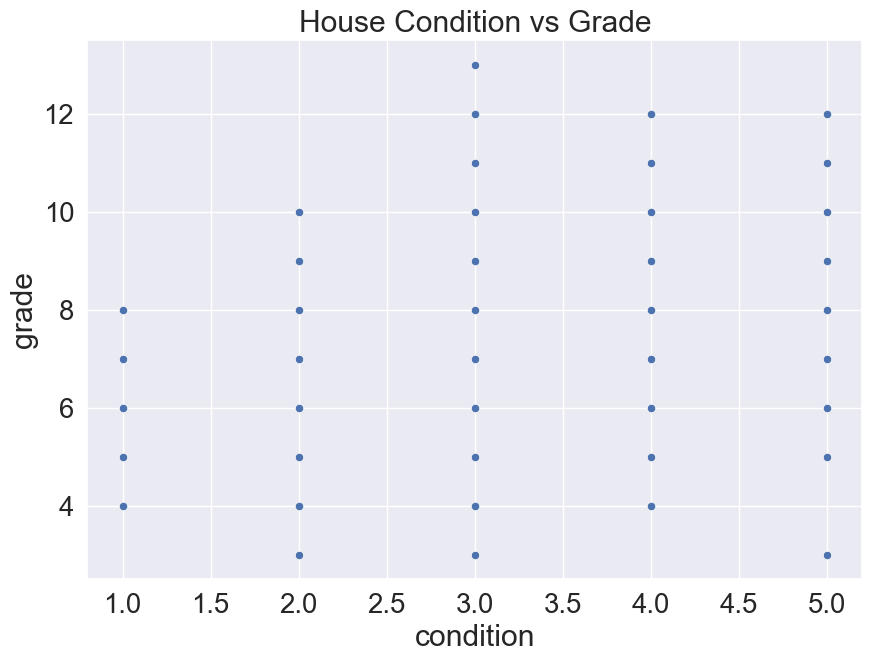

In [129]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x= "condition", y="grade")
plt.title('House Condition vs Grade')

We will do one hot encoding by creating dummies for all the condition values

In [130]:
cond_encod = pd.get_dummies(df['condition'], drop_first=True) 
df = df.drop('condition',axis = 1)
df = df.join(cond_encod)

Next, we will build a heat map to observe correlations among the independent variables like 'bedroom', 'bathroom' etc. for response variable 'price'

In [131]:
#Removing variables like zipcode as we cannot do linear regression and discern any patterns from there
x_col = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'grade',
       'sqft_above', 'yr_built', 'sqft_living15', 'sqft_lot15', 2, 3, 4, 5]
#2,3,4,5 are our dummy variables from one hot encoding of the condition, with bool true/false

df_update = df[x_col]
df_update['price'] = df['price']
df = df_update

/var/folders/j1/q4hz72_54jv6sn6fwy702r4c0000gn/T/ipykernel_8252/3344478033.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_update['price'] = df['price']


<Axes: >

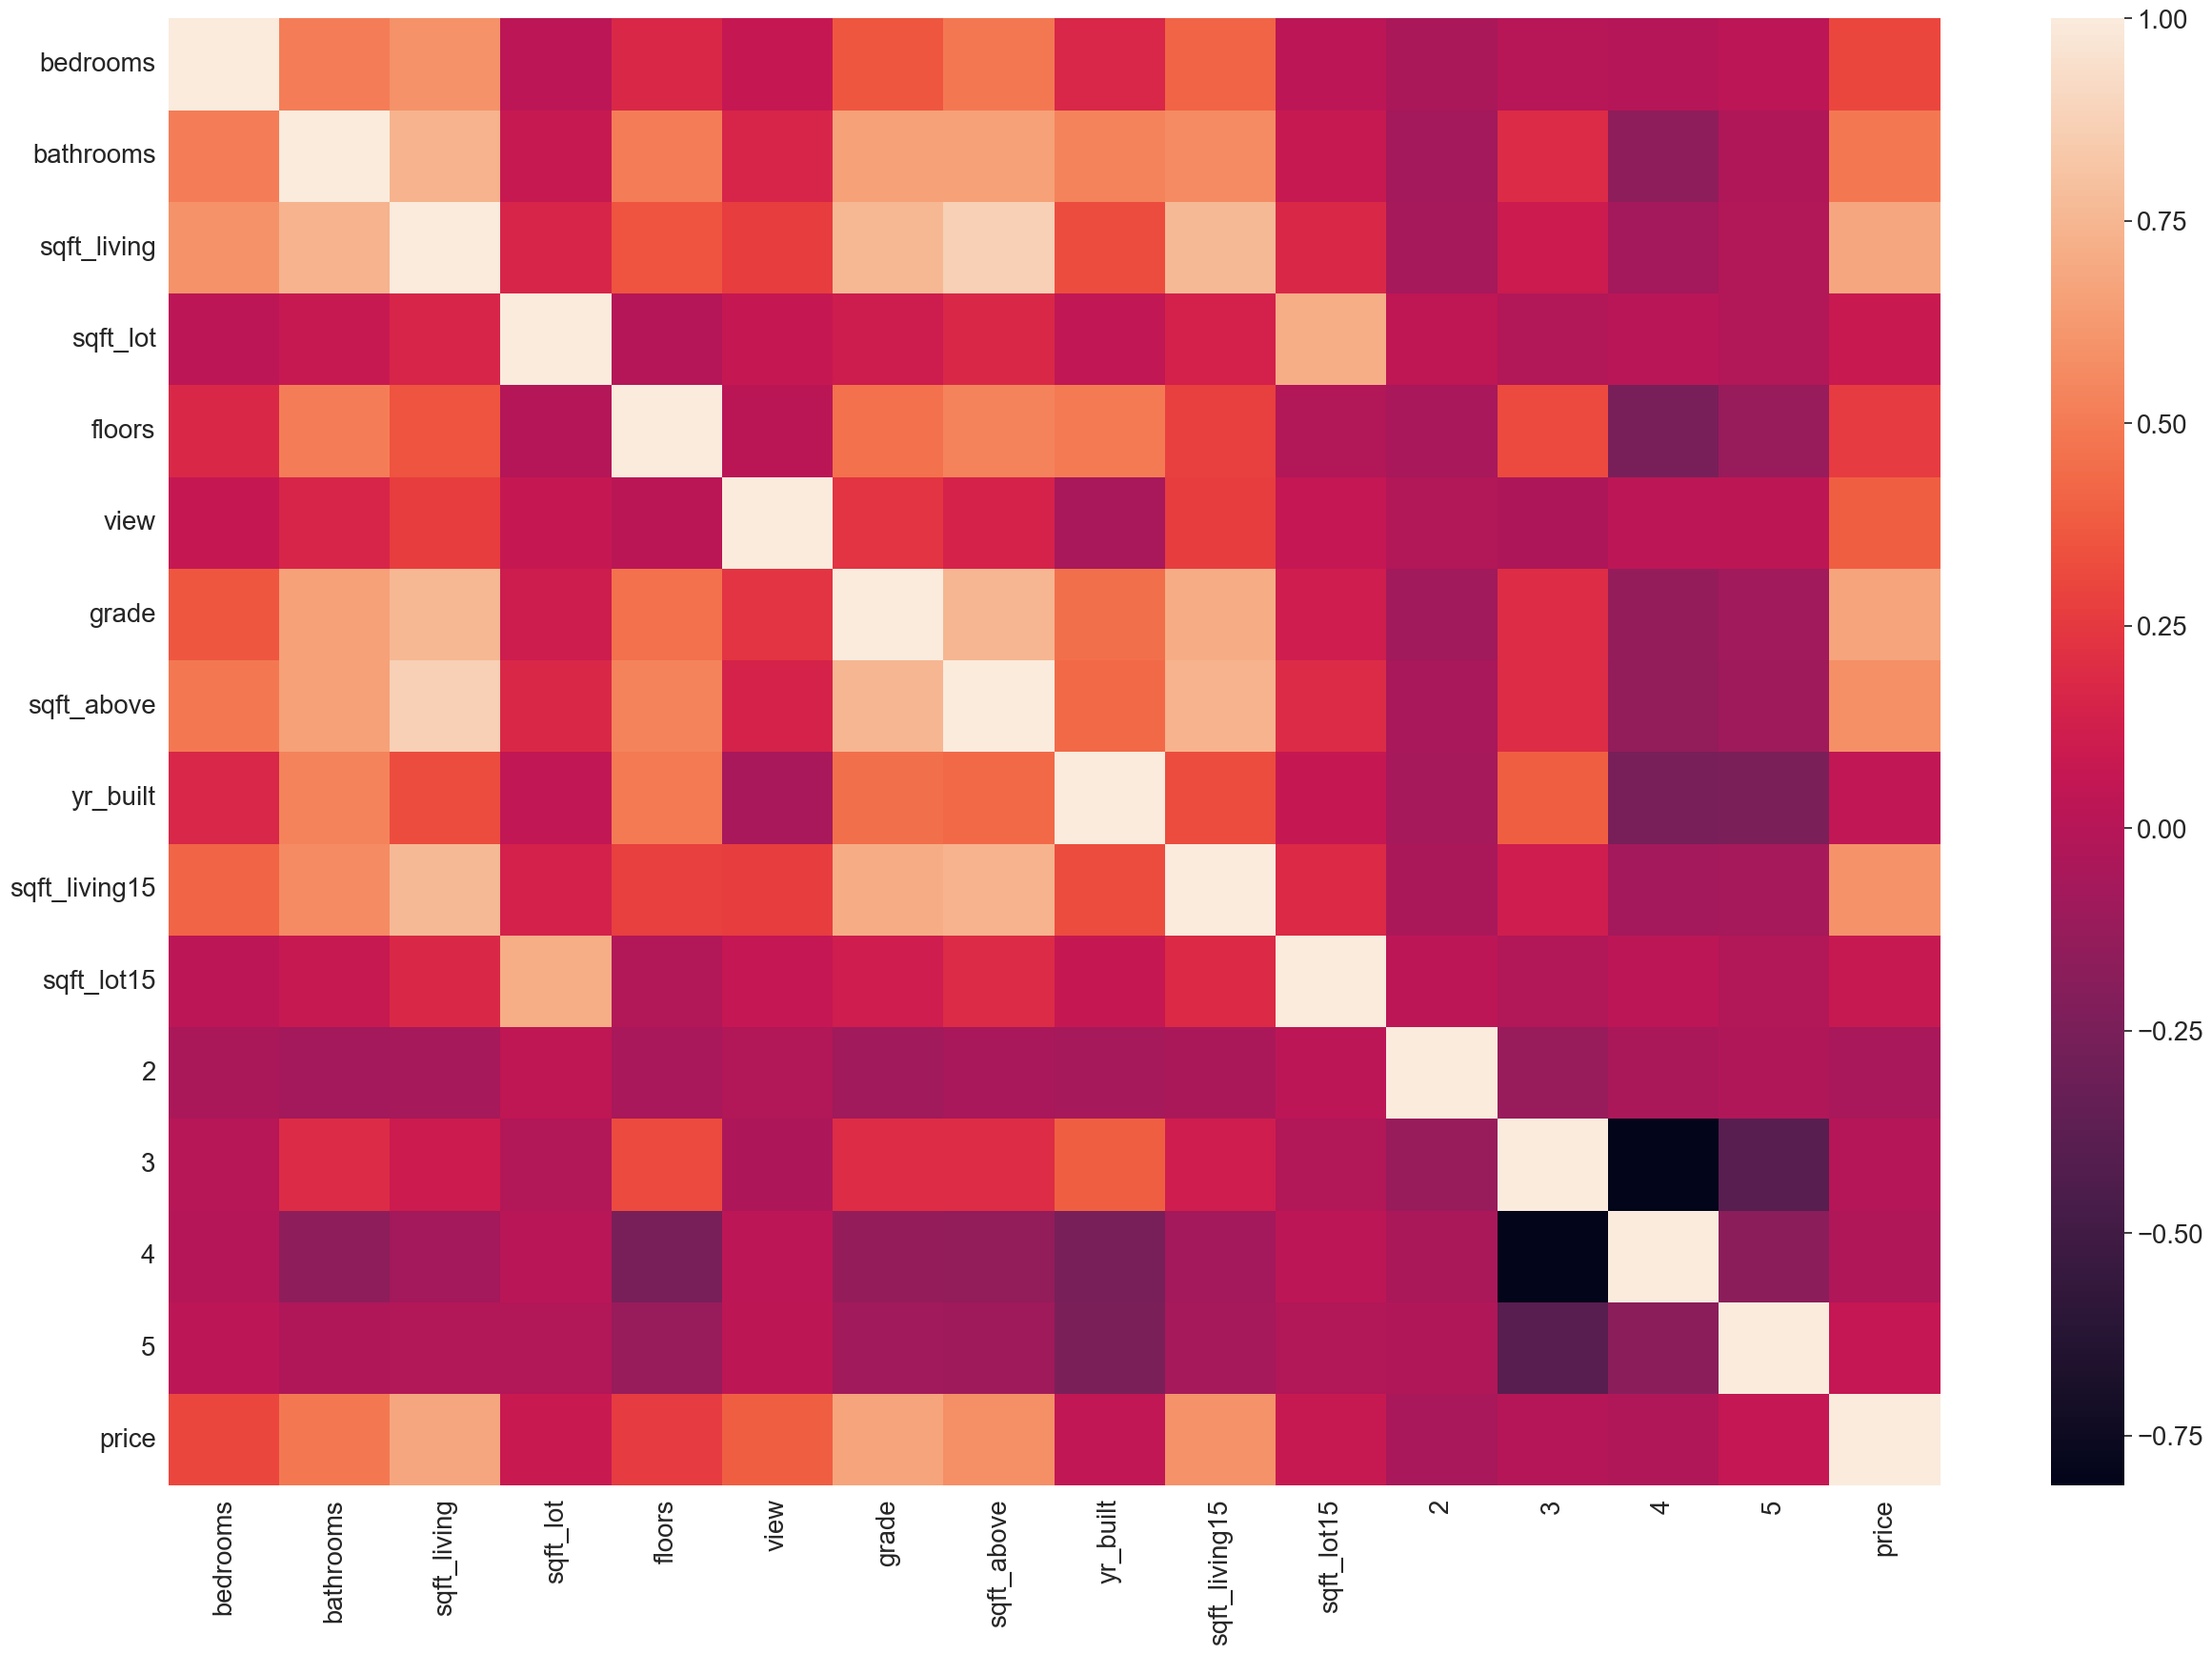

In [132]:
plt.figure(figsize=(30, 20))
corr = df.corr()
#sns.heatmap(corr, square=True, annot=True)
sns.set(font_scale=1.8)
sns.heatmap(corr)

In [133]:
corr['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.677608
grade            0.668190
sqft_living15    0.593759
sqft_above       0.578416
bathrooms        0.489144
view             0.387881
bedrooms         0.302235
floors           0.257723
sqft_lot         0.083669
sqft_lot15       0.077459
5                0.065628
yr_built         0.046354
3               -0.000030
4               -0.027269
2               -0.054863
Name: price, dtype: float64

Therefore, the top 4 factors all above 0.05 correlation coefficient are are: 

sqft_living： Size of living area in square feet
grade： Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value.
sqft_living15： Average size of interior housing living space for the closest 15 houses, in square feet
sqft_above： 	Square feet above ground

These factors are strongly correlated with price and will be used in building the linear regression models. Before doing the linear regression we have to convert the sqft_living and sqft_living 15 into logs as without it they are not normally distributed and not homoscedastic (meaning they are heteroscedastic). QQ plot shows us that

In [ ]:
df['price'] = np.log(df['price'])
df['sqft_living'] = np.log(df['sqft_living'])
df['sqft_living15'] = np.log(df['sqft_living15'])

Building Linear Regression Model: OLS

In [135]:
results = ols("price ~ sqft_living+grade + sqft_living15+ sqft_above", data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     6228.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        13:29:06   Log-Likelihood:                -7856.8
No. Observations:               21366   AIC:                         1.572e+04
Df Residuals:                   21361   BIC:                         1.576e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.9143      0.087     79.723      0.000       6.744       7.084
sqft_living       0.4240      0.011     36.972      0.000       0.401       0.446
grade             0.2000      0.003     58.863      0.000       0.193       0.207
sqft_living15     0.2049      0.012     17.491      0.000       0.182       0.228
sqft_above    -8.229e-05   5.86e-06    -14.032      0.000   -9.38e-05   -7.08e-05
==============================================================================
Omnibus:                       69.327   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.775
Skew:                           0.129   Prob(JB):                     1.16e-15
Kurtosis:                       2.894   Cond. No.                     7.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

r squared value 0.538. Next we calculate mean squared error to evaluate this OLS model

In [136]:
pred_vals = results.predict(df[['sqft_living', 'grade','sqft_living15','sqft_above']])
pred_vals

0        12.691724
1        12.987826
2        12.489555
3        12.920595
4        13.060845
           ...    
21608    13.000231
21609    13.147403
21610    12.587194
21611    12.996699
21612    12.587194
Length: 21366, dtype: float64

In [137]:
res = pd.concat([pred_vals.to_frame().rename(columns={0:'y_hat'}),df['price']], axis=1)
res


,y_hat,price
0,12.691724,12.309982
1,12.987826,13.195614
2,12.489555,12.100712
3,12.920595,13.311329
4,13.060845,13.142166
...,...,...
21608,13.000231,12.793859
21609,13.147403,12.899220
21610,12.587194,12.904459
21611,12.996699,12.899220


In [138]:
res['error'] = res['y_hat'] - res['price']
res['sq_error'] = res['error']**2
np.sqrt(res['sq_error'].mean())


0.3495124315908609

Mean squared error is 0.35

((array([-3.99431286, -3.77895082, -3.66113991, ...,  3.66113991,
          3.77895082,  3.99431286]),
  array([-1.48416535, -1.44007093, -1.40393889, ...,  1.10598797,
          1.11832768,  1.14149994])),
 (0.34930153226415483, -2.0170584090976652e-13, 0.9992168254093358))

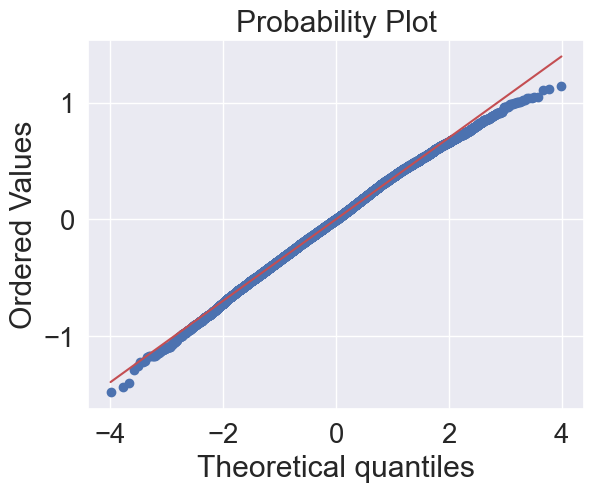

In [139]:
import scipy.stats as stats
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(res['error'], dist='norm', plot=ax)

QQplot with residulas has satisfied normality and homoscedasticity

Next we will try building a model using Linear Regression, Ridge, Elastic and Lasso from Scikit learn

In [170]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import mean_squared_error


In [162]:
numerical_features = ['sqft_living', 'grade', 'sqft_living15','sqft_above']
target = 'price'

In [163]:
# split data in train / test
X_train, X_test, y_train, y_test = train_test_split(df[numerical_features]
                                                    ,df[target],
                                                    test_size = 0.3, random_state=1234)

In [164]:
num_transformer = Pipeline(steps = [('scaler', StandardScaler())])

In [165]:
preprocessor = ColumnTransformer(transformers = [('num', num_transformer, numerical_features)])
                                               

In [166]:
linear_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [167]:
linear_regression.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['sqft_living', 'grade',
                                                   'sqft_living15',
                                                   'sqft_above'])])),
                ('regressor', LinearRegression())])

In [168]:
pred = linear_regression.predict(X_test)


In [169]:
pred


array([12.81501057, 12.79283711, 12.91486477, ..., 12.72477667,
       12.79763803, 12.90382802])

In [171]:
np.sqrt(mean_squared_error(pred,y_test))


0.3500201733586842

Linear Regression from scikit have identical MSE of 0.35 with OLS from statsmodel

In [175]:
#Ridge
ridge_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=3.0))
])
ridge_regression.fit(X_train, y_train)
pred_ridge = ridge_regression.predict(X_test)
np.sqrt(mean_squared_error(pred_ridge,y_test))

0.35001966363979015

Ridge has a MSE of 0.35 as well

In [176]:
#Lasso
lasso_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=1.0))
])
lasso_regression.fit(X_train, y_train)
lasso_pred = lasso_regression.predict(X_test)
np.sqrt(mean_squared_error(lasso_pred, y_test))



0.5074709975745192

Lasso w/ MSE of 0.5

In [177]:
#Elastic
elasticnet_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=1.0, l1_ratio=0.8))
])
elasticnet_regression.fit(X_train, y_train)
elasticnet_pred = elasticnet_regression.predict(X_test)
np.sqrt(mean_squared_error(elasticnet_pred, y_test))


0.5074709975745192

Elastic has MSE of 0.5

1) In the King County housing price data: we have built 5 different regression models including OLS of statsmodel, linear regression, lasso, elastic and ridge from scikit learning. Before building the models, we checked and removed outliers, created dummy variables through one hot encoding of the conditions column and dropped the orignial condition column as the data didn't make sense in that format. Further, through heat map of multicollinearity coupled with qq plot, we saw that sqft_living and sqft_living15 requires logarithic conversion with price to satisfy normal distribution and homoscedasticity

2) Either the OLS, Linear Regression or Ridge model would provide us with the best predictor of price in the King County house data. OLS and Linear Regression had an identical MSE of 0.35. The mean squared error or MSE in both instances were 0.35 lower than 0.5 of Elastic and Lasso model. Thus, OLS, Linear Regression and Ridge are the model to evaluate predictor variables for the response variable of price.

In [180]:
results = ols("price ~ sqft_living+grade + sqft_living15+ sqft_above", data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     6228.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:31:00   Log-Likelihood:                -7856.8
No. Observations:               21366   AIC:                         1.572e+04
Df Residuals:                   21361   BIC:                         1.576e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.9143      0.087     79.723      0.000       6.744       7.084
sqft_living       0.4240      0.011     36.972      0.000       0.401       0.446
grade             0.2000      0.003     58.863      0.000       0.193       0.207
sqft_living15     0.2049      0.012     17.491      0.000       0.182       0.228
sqft_above    -8.229e-05   5.86e-06    -14.032      0.000   -9.38e-05   -7.08e-05
==============================================================================
Omnibus:                       69.327   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.775
Skew:                           0.129   Prob(JB):                     1.16e-15
Kurtosis:                       2.894   Cond. No.                     7.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

3)Explaining the results:

In King County, top factors affecting the house price are square footage of the inhabitable space, interior square footage of 15 closest neighbor's house, grade from King County (higher grade means cost of building the houser higher so the house is worth more). If we look at the coef table, we see square foot living has a coeffcient of 0.42 meaning for 1 square footage increase of living space, the average house value will increase by $4200 (because of the logarithmic transformation). interior square footage of 0.2 indicates 1 square footage increase of interiorliving space among 15 neighbor's house, the average house value will increase by $4200. On the same token, grading of house has a 0.2 coefficient meaning for every increase in grade the average house price increase by $2000. The square foot above ground for the house has negligible impact on house price.

However, it's important to acknowledge that the model has certain limitations. To satisfy regression assumptions, certain variables (sqft_living, sqft_living15) had to undergo log transformation , implying that any new data used with the model would require similar preprocessing. Furthermore, due to regional variations in housing prices, the model's effectiveness with data from other counties might be restricted. This OLS model is only applicable with the data presented in King's County.
